# Task 3: Exploratory Data Analysis(EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("NewDataset/cleaned_dataset.csv", parse_dates = ['Date'])
df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,Courier Status,Qty,Amount,ship-city,ship-state,ship-postal-code,B2B,Order Sucess,Weekday,Total items
0,0,405-8078784-5731545,2022-04-30,Cancelled,merchant,amazon.in,standard,SET389,SET389-KR-NP-S,Set,...,cancelled,0,647.62,MUMBAI,Maharashtra,400081.0,False,False,Saturday,1
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,merchant,amazon.in,standard,JNE3781,JNE3781-KR-XXXL,kurta,...,shipped,1,406.00,BENGALURU,Karnataka,560085.0,False,True,Saturday,1
2,2,404-0687676-7273146,2022-04-30,Shipped,amazon,amazon.in,expedited,JNE3371,JNE3371-KR-XL,kurta,...,shipped,1,329.00,NAVI MUMBAI,Maharashtra,410210.0,True,False,Saturday,1
3,3,403-9615377-8133951,2022-04-30,Cancelled,merchant,amazon.in,standard,J0341,J0341-DR-L,Western Dress,...,cancelled,0,753.33,PUDUCHERRY,Puducherry,605008.0,False,False,Saturday,1
4,4,407-1069790-7240320,2022-04-30,Shipped,amazon,amazon.in,expedited,JNE3671,JNE3671-TU-XXXL,Top,...,shipped,1,574.00,CHENNAI,Tamil Nadu,600073.0,False,False,Saturday,1


# Business model: Trying to minimise the number of cancelled products 

## 1. Products with quantity 0 contribute the most to the cancelled products list. Also, these products do not contribute anything to the revenue as their amounts are missing.

Text(0, 0.5, 'Number of orders')

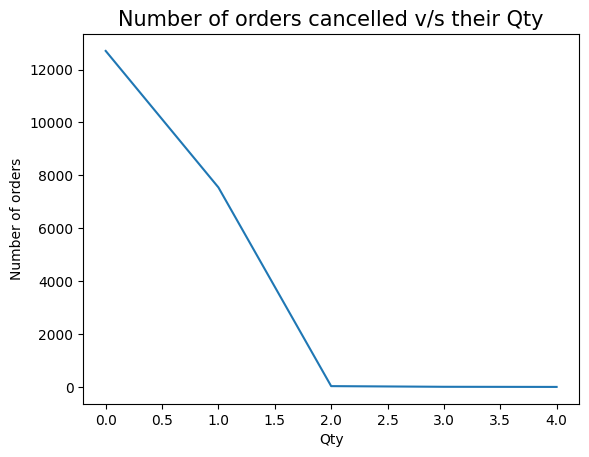

In [3]:
df[df['Status'].isin(['Cancelled', 'Shipped - Returned to Seller'])]['Qty'].value_counts().plot()
plt.title('Number of orders cancelled v/s their Qty', fontsize = 15)
plt.ylabel('Number of orders')

Text(0, 0.5, 'No. of orders')

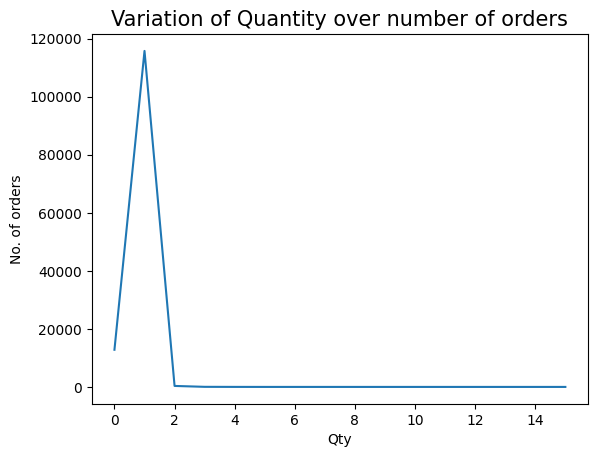

In [4]:
df['Qty'].value_counts().sort_index().plot()
plt.title('Variation of Quantity over number of orders', fontsize = 15)
plt.ylabel('No. of orders')

### INSIGHTS:
##### Even if there is no costing for shipping for these products, it is still bad for network traffic on the website. Hence removing the zero quantity option is necessary

## 2. Products with more return are bad for business, there are multiple such products on which the we spend for buying, shipping, delivery and then returning again. These products must be removed from the stocks

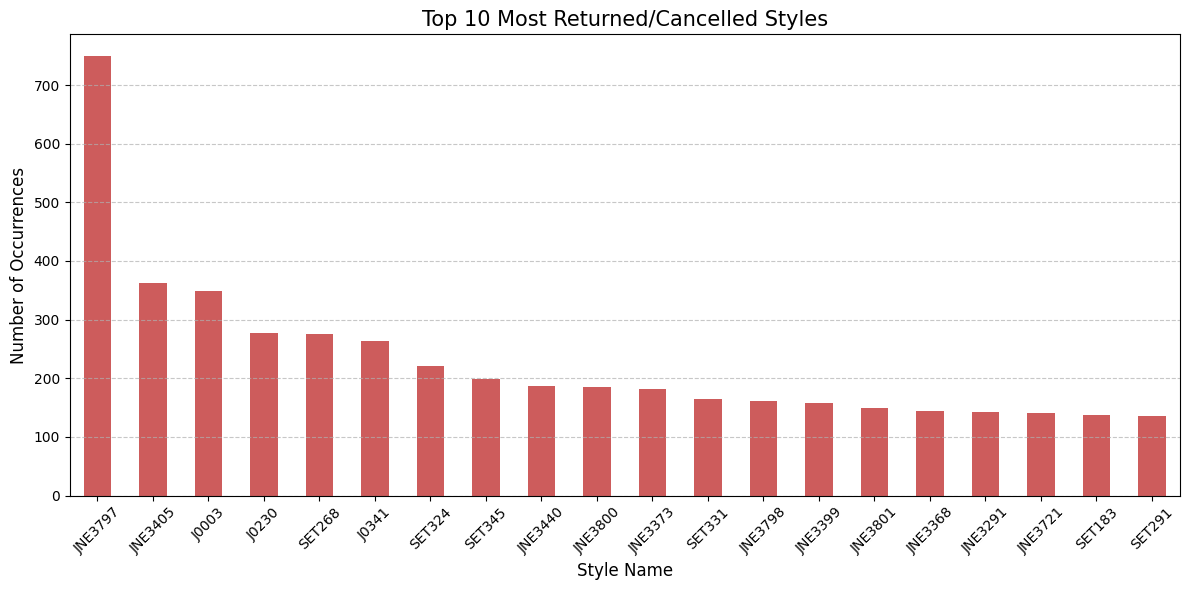

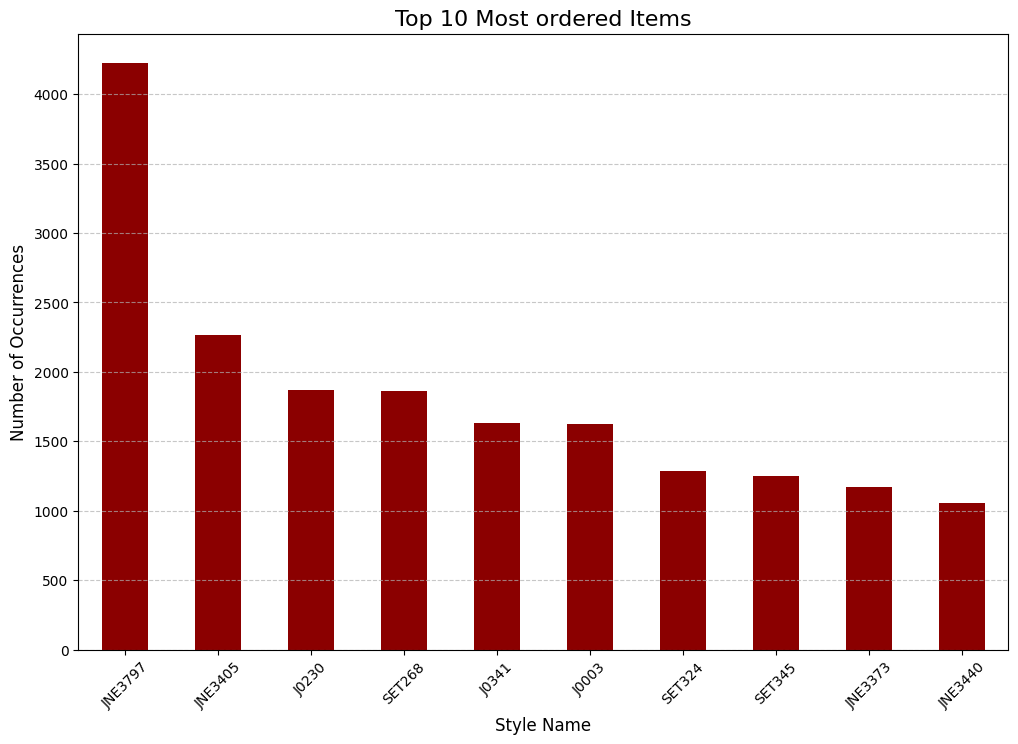

In [5]:
# 1. Filter for cancelled/returned status
canc = ['Cancelled', 'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer', 'Shipped - Damaged']
cancelled_df = df[df['Status'].isin(canc)]

top_10_styles = cancelled_df['Style'].value_counts().head(20)

plt.figure(figsize=(12, 6))
top_10_styles.plot(kind='bar', color='indianred')

plt.title('Top 10 Most Returned/Cancelled Styles', fontsize=15)
plt.xlabel('Style Name', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
print()

top_10_st = df['Style'].value_counts().head(10)
plt.figure(figsize = (12, 8))
top_10_st.plot(kind = 'bar', color = 'darkred')
plt.title('Top 10 Most ordered Items', fontsize = 16)
plt.xlabel('Style Name', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

### INSIGHTS:
#### The above products have a high order reduction rate, and these values are likely to go up with even less expected orders for these products. Hence reducing the stock or removing them would improve the sales

#### Products with the highest are also the products with the highest ordering rate, so instead of removing them. We remove only those products that are returned at least 30% percent of the times

In [9]:
canc_statuses = ['Cancelled', 'Shipped - Rejected by Buyer', 'Shipped - Returning to Seller', 'Shipped - Damaged', 'Shipped - Lost in Transit']

# 2. Explicitly create the boolean column to avoid the Error
df['is_cancelled'] = df['Status'].isin(canc_statuses)

# 3. Perform the grouping (doing it once for efficiency)
# We calculate Total Count, Cancelled Count, and Sum of Amount Lost
stats = df.groupby('Style').agg(
    Total_Orders=('Order ID', 'nunique'),
    Cancelled_Orders=('is_cancelled', 'sum'), # sum() works on booleans (True=1, False=0)
    Amount_Lost=('Amount', lambda x: x[df.loc[x.index, 'is_cancelled']].sum())
).fillna(0)

# 4. Calculate the Return Rate
stats['Return_Rate_%'] = (stats['Cancelled_Orders'] / stats['Total_Orders']) * 100

# 5. Filter for High-Risk Styles (Volume > 5 and Rate > 30%)
high_risk_styles = stats[(stats['Total_Orders'] > 5) & (stats['Return_Rate_%'] > 30)]

# 6. Final Results
total_loss = high_risk_styles['Amount_Lost'].sum()
num_styles = len(high_risk_styles)

print(f"Number of High-Risk Styles (>30% return): {num_styles}")
print(f"Total Revenue Lost from these specific styles: ₹{total_loss:,.2f}")

# Display top 10 worst offenders by financial loss
print("\nTop 10 Loss-Making Styles:")
print(high_risk_styles.sort_values('Amount_Lost', ascending=False).head(10))

Number of High-Risk Styles (>30% return): 16
Total Revenue Lost from these specific styles: ₹38,320.47

Top 10 Loss-Making Styles:
         Total_Orders  Cancelled_Orders  Amount_Lost  Return_Rate_%
Style                                                              
SET195             24                10      7213.46      41.666667
JNE3608            77                28      6211.80      36.363636
J0226              13                 4      5835.39      30.769231
JNE3408            46                15      4730.15      32.608696
J0350              43                13      3110.20      30.232558
JNE3909            12                 4      2054.86      33.333333
JNE3257            17                 6      1684.86      35.294118
JNE3488            21                 7      1466.52      33.333333
SET274             13                 4      1329.14      30.769231
BTM002             18                 6      1036.00      33.333333


#### These products generate a potential business loss of ₹75,0000 every 90 days. Removing them would increase the business profit

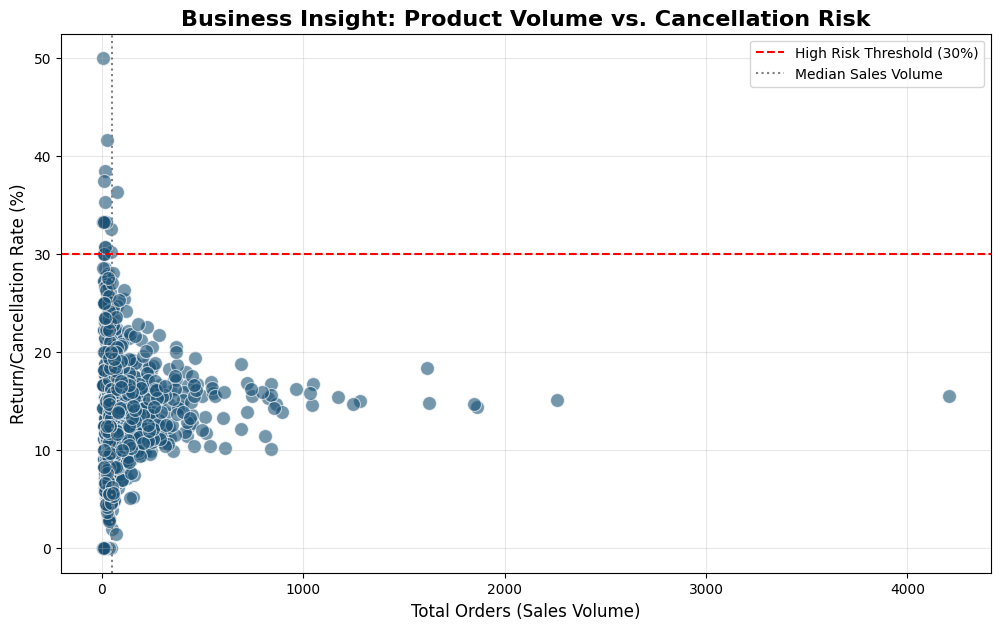

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Ensure the data is prepared correctly
# (We recreate the statistics from the last fixed step)
df['is_cancelled'] = df['Status'].isin(['Cancelled', 'Shipped - Rejected by Buyer', 'Shipped - Returning to Seller'])

stats = df.groupby('Style').agg(
    Total_Orders=('Order ID', 'nunique'),
    Cancelled_Orders=('is_cancelled', 'sum')
)
stats['Return_Rate_%'] = (stats['Cancelled_Orders'] / stats['Total_Orders']) * 100

# This creates the variable the scatterplot needs
significant_products = stats[stats['Total_Orders'] > 5]

# 2. Plotting
plt.figure(figsize=(12, 7))

# We use 'hue' to color points by their return rate for better insight
sns.scatterplot(data=significant_products, 
                x='Total_Orders', 
                y='Return_Rate_%', 
                alpha=0.6, 
                s=100, # Increases point size
                color='#1a5276') 

# 3. Add Business Logic Lines (KPI Thresholds)
plt.axhline(y=30, color='red', linestyle='--', label='High Risk Threshold (30%)')
plt.axvline(x=significant_products['Total_Orders'].median(), color='gray', linestyle=':', label='Median Sales Volume')

plt.title('Business Insight: Product Volume vs. Cancellation Risk', fontsize=16, fontweight='bold')
plt.xlabel('Total Orders (Sales Volume)', fontsize=12)
plt.ylabel('Return/Cancellation Rate (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## 3. Remove products whose sales is going down
##### There are multiple products with peak order rates and contributing effectively to the sales. But their ordering rates are reducing drastically, hence products like these should be taken out. 

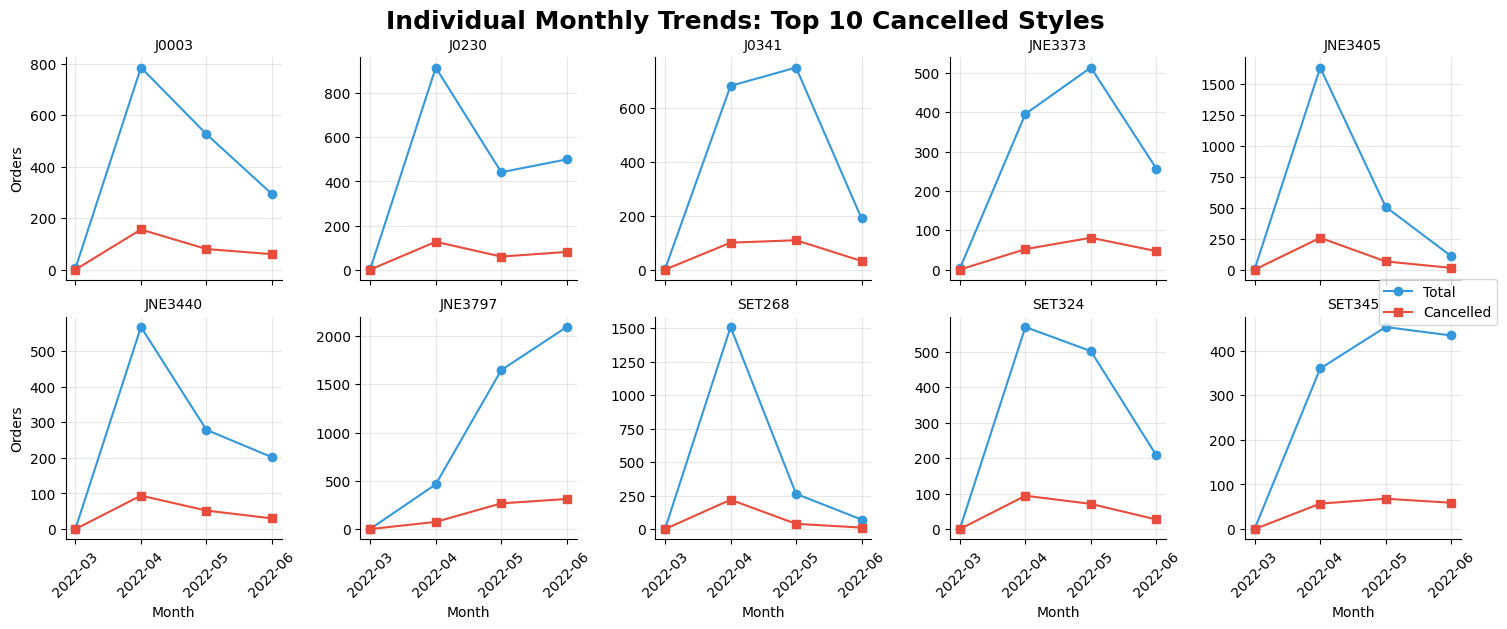

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Identify Top 10 problematic styles (as done before)
top_10_cancelled_styles = df[df['is_cancelled']]['Style'].value_counts().head(10).index
top_10_df = df[df['Style'].isin(top_10_cancelled_styles)].copy()

# 2. Prepare Time Data
top_10_df['Month'] = top_10_df['Date'].dt.to_period('M').astype(str)

# 3. Aggregate Monthly stats per Style
individual_trend = top_10_df.groupby(['Month', 'Style']).agg(
    Total_Orders=('Order ID', 'nunique'),
    Cancelled_Orders=('is_cancelled', 'sum')
).reset_index()

# 4. Create the Facet Grid (Individual charts for each Style)
g = sns.FacetGrid(individual_trend, col="Style", col_wrap=5, height=3, sharey=False)

# Plot Total Orders (Blue)
g.map(plt.plot, "Month", "Total_Orders", marker="o", color="#3498db", label="Total")
# Plot Cancelled Orders (Red)
g.map(plt.plot, "Month", "Cancelled_Orders", marker="s", color="#e74c3c", label="Cancelled")

# 5. Formatting
g.set_axis_labels("Month", "Orders")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Individual Monthly Trends: Top 10 Cancelled Styles', fontsize=18, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
plt.show()

In [36]:
df['Month'] = pd.to_datetime(df['Date']).dt.to_period('M').astype(str)
monthly_sales = df.groupby(['Style', 'Month']).agg(
    Monthly_Orders=('Order ID', 'nunique')
).reset_index()

style_stats = monthly_sales.groupby('Style').agg(
    Peak_Orders=('Monthly_Orders', 'max'),
    Current_Orders=('Monthly_Orders', 'last'),
    Last_Month=('Month', 'last'),
    Peak_Month=('Monthly_Orders', 'idxmax') # Find when the peak happened
)

style_stats['Retention_Ratio_%'] = (style_stats['Current_Orders'] / style_stats['Peak_Orders']) * 100
style_stats['Order_Reduction_Rate'] = 100 - style_stats['Retention_Ratio_%']

fading_stars = style_stats[(style_stats['Peak_Orders'] > 10) & 
                           (style_stats['Order_Reduction_Rate'] > 60)].sort_values('Order_Reduction_Rate', ascending=False)

print("Fastest Moving Down:")
print(fading_stars[['Peak_Orders', 'Current_Orders', 'Order_Reduction_Rate']].head(10))

Fastest Moving Down:
         Peak_Orders  Current_Orders  Order_Reduction_Rate
Style                                                     
SET257            83               2             97.590361
JNE3574           28               1             96.428571
J0161             23               1             95.652174
JNE3531           22               1             95.454545
J0140             21               1             95.238095
SET268          1510              72             95.231788
JNE3488           20               1             95.000000
J0414             38               2             94.736842
SET138            19               1             94.736842
SET110           427              24             94.379391


### INSIGHTS:
##### There are multiple products that have high order reduction rate with almost 98% reduction. Hence these are seasonal products and must be removed from the stock

## 4. Potential business loss for orders due to delay in delivery/shipping.

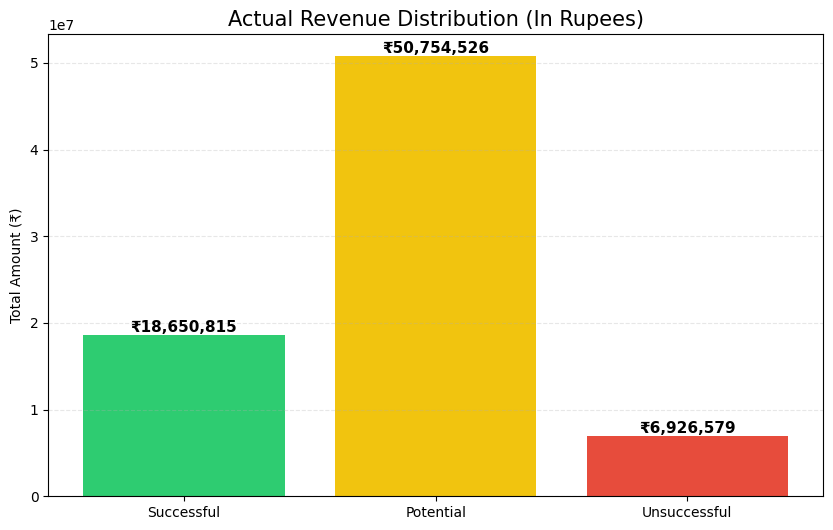

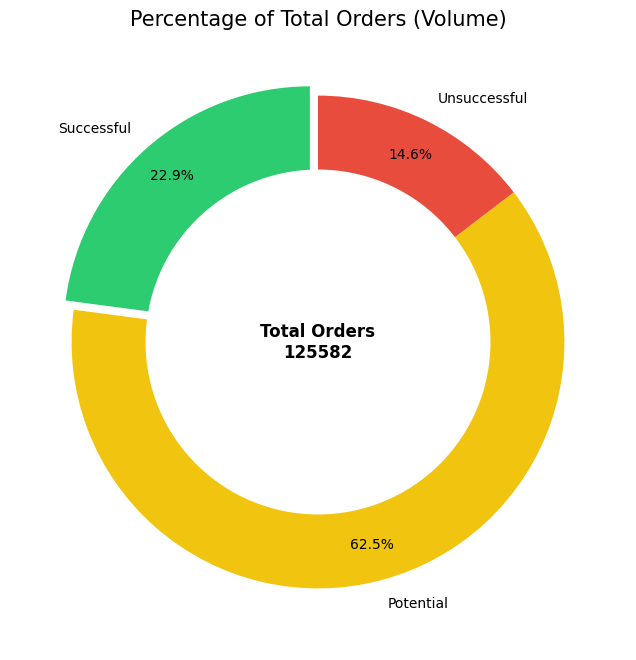

In [40]:
df_success = df[df['Status'] == 'Shipped - Delivered to Buyer']
pending_df = df[df['Status'].isin(['Shipped', 'Pending', 'Shipping'])] # Add your list here
cancelled_df = df[df['Status'].isin(['Cancelled', 'Shipped - Rejected by Buyer'])] # Add your list here

labels = ['Successful', 'Potential', 'Unsuccessful']
amounts = [df_success['Amount'].sum(), pending_df['Amount'].sum(), cancelled_df['Amount'].sum()]
colors = ['#2ecc71', '#f1c40f', '#e74c3c']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, amounts, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'₹{int(yval):,}', 
             va='bottom', ha='center', fontweight='bold', fontsize=11)

plt.title('Actual Revenue Distribution (In Rupees)', fontsize=15)
plt.ylabel('Total Amount (₹)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

counts = [len(df_success), len(pending_df), len(cancelled_df)]

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, 
        colors=colors, pctdistance=0.85, explode=(0.05, 0, 0))

center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.title('Percentage of Total Orders (Volume)', fontsize=15)
plt.annotate(f'Total Orders\n{sum(counts)}', (0,0), ha='center', va='center', 
             fontsize=12, fontweight='bold')
plt.show()

------------------------------
     EXECUTIVE KPI REPORT     
------------------------------
Total Potential Revenue: ₹78,592,678.30
Revenue Lost (Cancelled): ₹7,034,199.30
Revenue at Risk (Pending): ₹50,946,664.00
Overall Success Rate: 22.3%
Avg. Pending Order Age: 46.6 Days
------------------------------


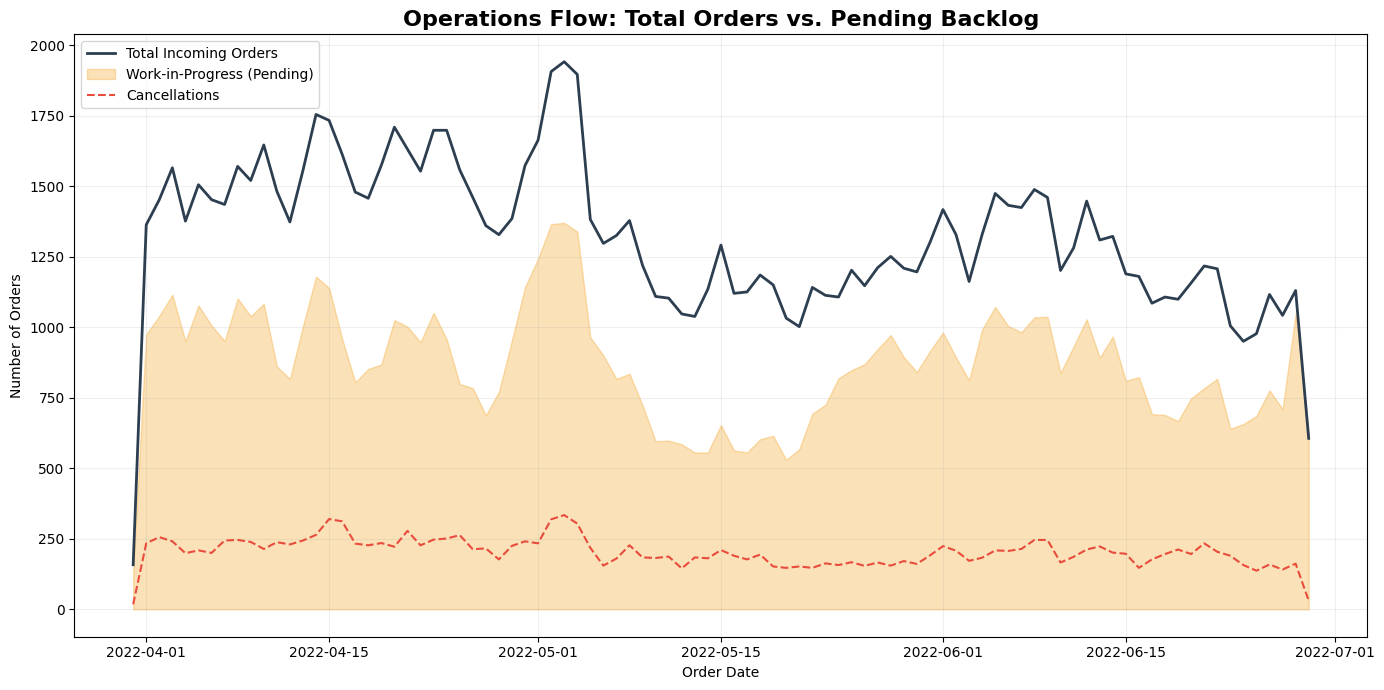

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. SETUP & DATA CLEANING ---
df['Date'] = pd.to_datetime(df['Date'])
# Define status groups
canc = ['Cancelled', 'Shipped - Rejected by Buyer', 'Shipped - Returning to Seller']
pending = ['Pending', 'Shipping', 'Shipped', 'Pending - Waiting for Pick Up']
success = ['Delivered', 'Shipped - Delivered to Buyer']

df['is_cancelled'] = df['Status'].isin(canc)
df['is_pending'] = df['Status'].isin(pending)

# --- 2. CALCULATE KPIs ---
total_revenue = df['Amount'].sum()
revenue_lost = df[df['is_cancelled']]['Amount'].sum()
revenue_at_risk = df[df['is_pending']]['Amount'].sum()
success_rate = (len(df[df['Status'].isin(success)]) / len(df)) * 100

# Calculate Backlog Aging
latest_date = df['Date'].max()
pending_orders = df[df['is_pending']].copy()
pending_orders['age'] = (latest_date - pending_orders['Date']).dt.days
avg_backlog_age = pending_orders['age'].mean()

# --- 3. PRINT EXECUTIVE SUMMARY ---
print("-" * 30)
print("     EXECUTIVE KPI REPORT     ")
print("-" * 30)
print(f"Total Potential Revenue: ₹{total_revenue:,.2f}")
print(f"Revenue Lost (Cancelled): ₹{revenue_lost:,.2f}")
print(f"Revenue at Risk (Pending): ₹{revenue_at_risk:,.2f}")
print(f"Overall Success Rate: {success_rate:.1f}%")
print(f"Avg. Pending Order Age: {avg_backlog_age:.1f} Days")
print("-" * 30)

# --- 4. VISUALIZATION: TREND OF COMPLETED VS. UNCOMPLETED ---
# Grouping data by date
daily_stats = df.groupby('Date').agg(
    Total_Orders=('Order ID', 'nunique'),
    Pending_Orders=('is_pending', 'sum'),
    Cancelled_Orders=('is_cancelled', 'sum')
).reset_index()

plt.figure(figsize=(14, 7))

# Plotting the lines
plt.plot(daily_stats['Date'], daily_stats['Total_Orders'], label='Total Incoming Orders', color='#2c3e50', lw=2)
plt.fill_between(daily_stats['Date'], daily_stats['Pending_Orders'], color='#f39c12', alpha=0.3, label='Work-in-Progress (Pending)')
plt.plot(daily_stats['Date'], daily_stats['Cancelled_Orders'], label='Cancellations', color='#e74c3c', ls='--')

# Formatting
plt.title('Operations Flow: Total Orders vs. Pending Backlog', fontsize=16, fontweight='bold')
plt.ylabel('Number of Orders')
plt.xlabel('Order Date')
plt.legend(loc='upper left')
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

#### The orders in transit make 62% of the business for the company. Delaying the shipping could lead to cancelled orders and loss of potential future customers. The average age of an order pending is 46 days!!! This needs work
### Solution:

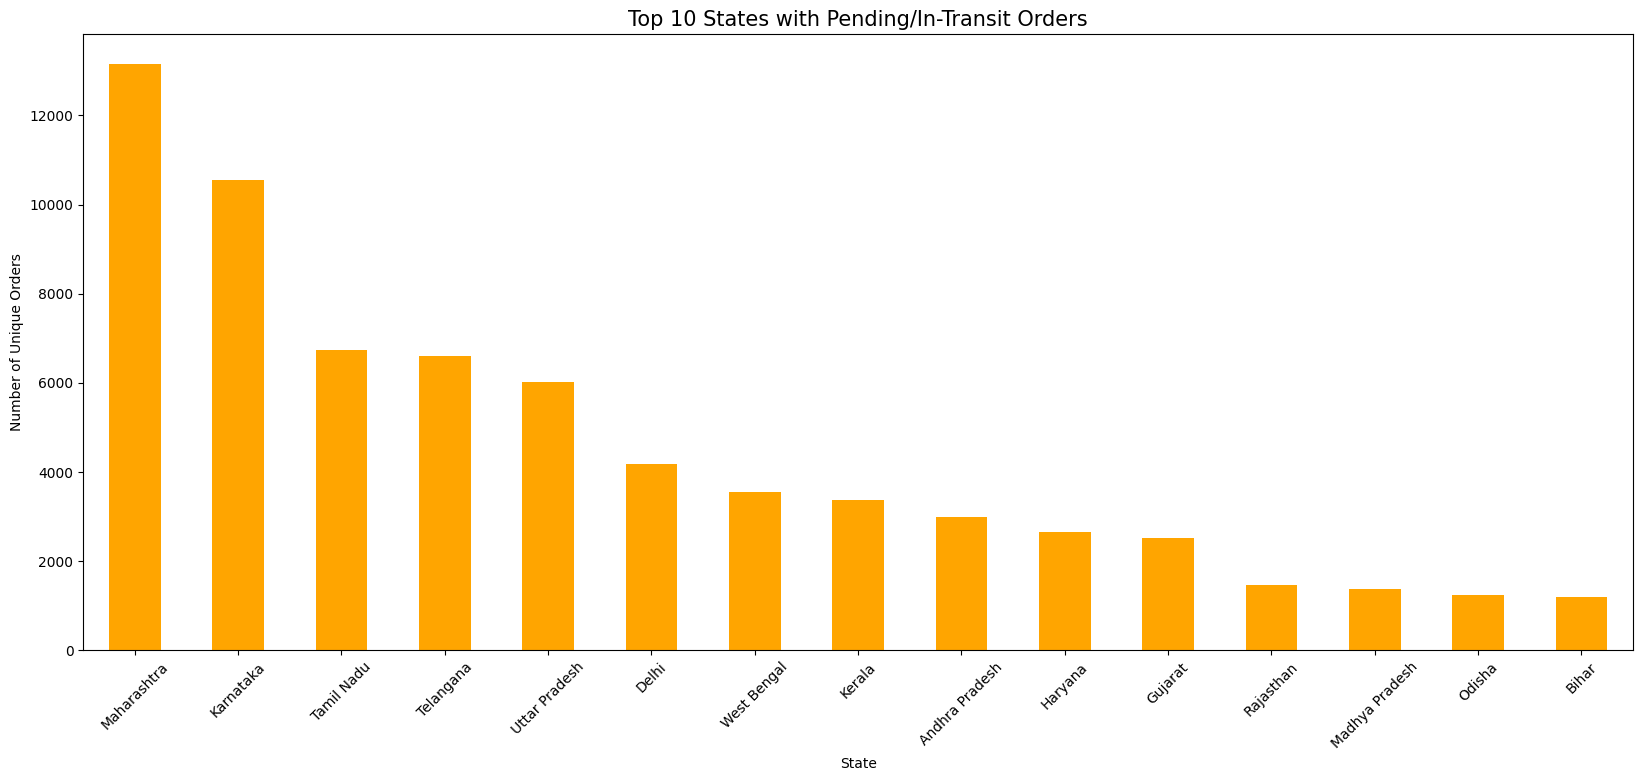

In [13]:
df_success = df[df['Status'] == 'Shipped - Delivered to Buyer']
pending = ['Shipped', 'Shipped - Lost in Transit', 'Shipped - Out for Delivery', 'Shipped - Picked Up', 'Pending', 'Pending - Waiting for Pick Up', 'Shipping']
pending_df = df[df['Status'].isin(pending)]

state_info = pending_df.groupby('ship-state')['Order ID'].nunique().sort_values(ascending = False)

plt.figure(figsize = (20, 8))
state_info.head(15).plot(kind='bar', color='orange')
plt.title('Top 10 States with Pending/In-Transit Orders', fontsize=15)
plt.ylabel('Number of Unique Orders')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.show()

### INSIGHTS
#### Increasing the number of delivery partners for the top 5 states would lead to faster deliveries and changing the potential profit into persistent ones. Faster deliveries could also help making multiple passive users becoming commited ones.

## 5. Expedited deliveries have lower percentage of cancellation than the standard delivery orders. Hence faster deliveries would amount to more successful orders.

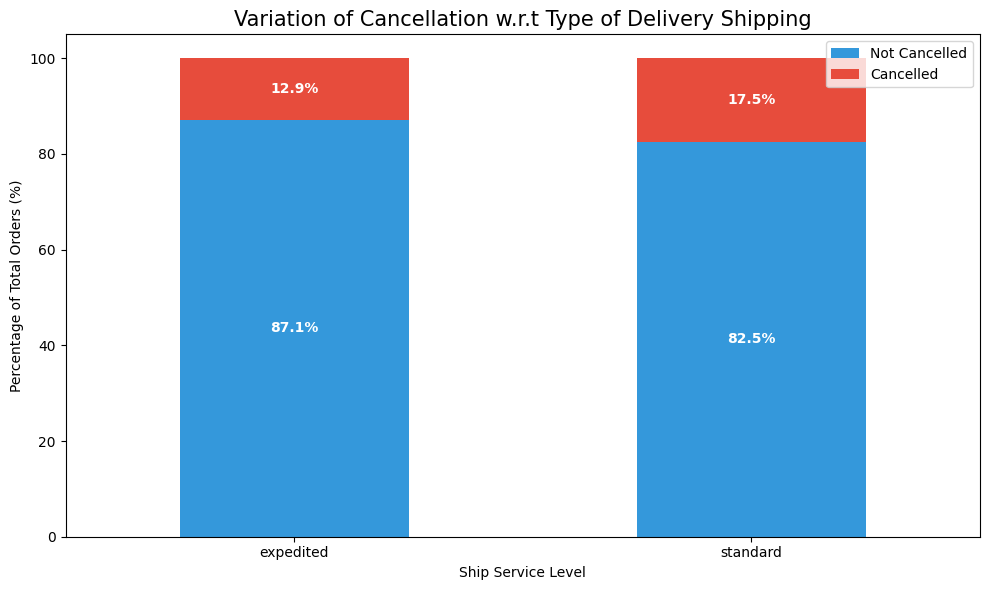

In [14]:
import matplotlib.pyplot as plt

service_trend = pd.crosstab(df['ship-service-level'], df['is_cancelled'], normalize='index') * 100
service_trend.columns = ['Not Cancelled', 'Cancelled']

ax = service_trend.plot(kind='bar', stacked=True, color=['#3498db', '#e74c3c'], figsize=(10, 6))

# 3. Add formatting
plt.title('Variation of Cancellation w.r.t Type of Delivery Shipping', fontsize=15)
plt.ylabel('Percentage of Total Orders (%)')
plt.xlabel('Ship Service Level')
plt.xticks(rotation=0)
plt.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

### Insights:

We can see that the cancelled rate for the orders with slower delivery methods are higher. Hence using faster delivery method or improving standard delivery would reduce the number of cancllations

## 6. By looking at the previous trends, we can add more delivery partners during the peak season when there are more orders and reduce them, when the number of orders are less, to enable faster deliveries

Busiest Dates:
         Date  Order Count
33 2022-05-03         1941
32 2022-05-02         1906
34 2022-05-04         1896
14 2022-04-14         1754
15 2022-04-15         1733
20 2022-04-20         1709
24 2022-04-24         1698
23 2022-04-23         1698
31 2022-05-01         1663
10 2022-04-10         1646


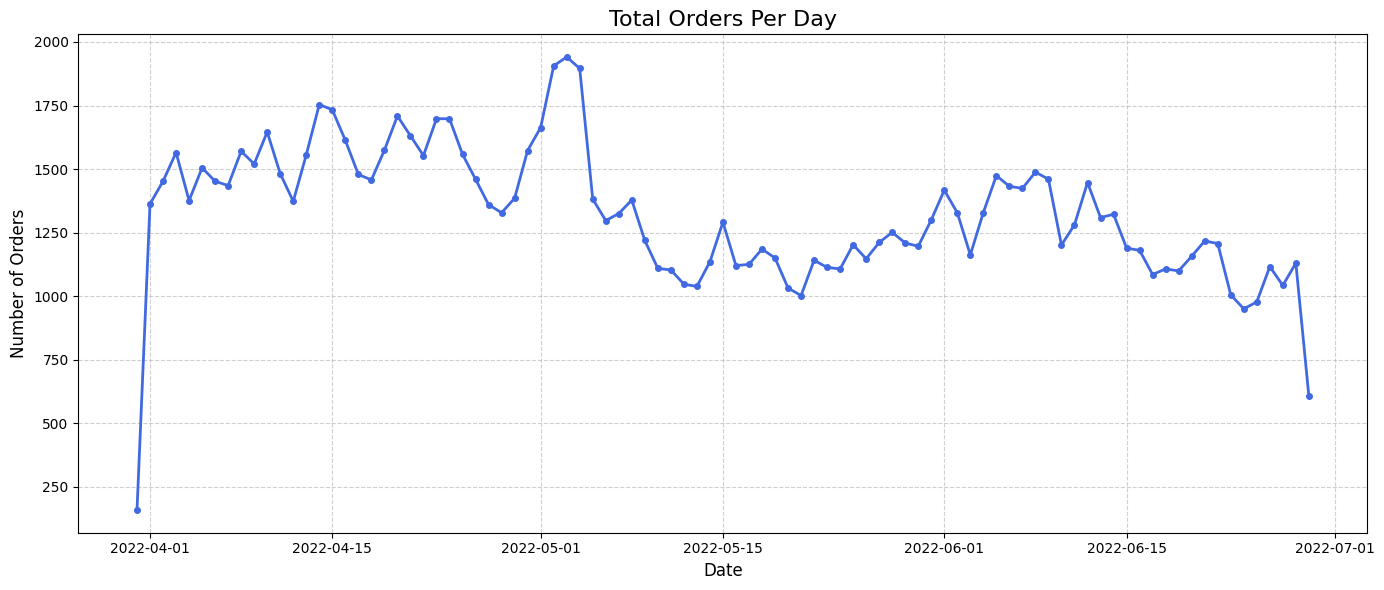

In [15]:
# 1. Group by Date and count UNIQUE Order IDs
daily_orders = df.groupby('Date')['Order ID'].nunique().reset_index()
daily_orders.columns = ['Date', 'Order Count']

# 2. Sort by date to see the trend chronologically
daily_orders = daily_orders.sort_values('Date')

# 3. Get the Top 10 busiest dates
top_10_dates = daily_orders.sort_values('Order Count', ascending=False).head(10)
print("Busiest Dates:")
print(top_10_dates)

# 4. Plotting the trend over time
plt.figure(figsize=(14, 6))
plt.plot(daily_orders['Date'], daily_orders['Order Count'], color='royalblue', marker='o', markersize=4, linewidth=2)

plt.title('Total Orders Per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation= 0)
plt.tight_layout()
plt.show()


#### Same could be applied for days of the week.

<Axes: xlabel='Weekday'>

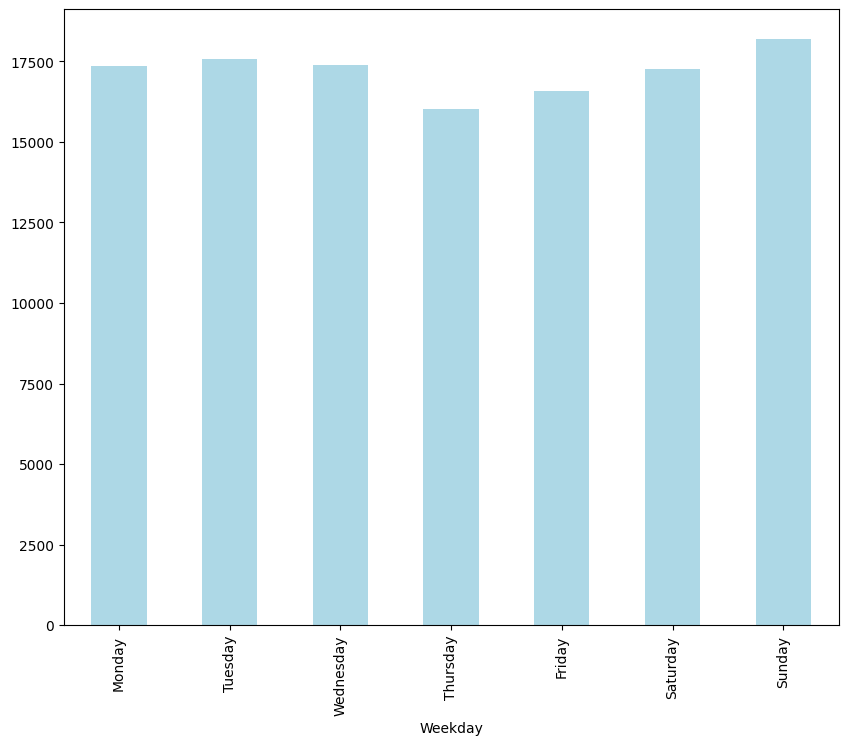

In [16]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_group = df.groupby('Weekday')['Order ID'].nunique().reindex(day_order)

day_group.plot(kind = 'bar', color = 'lightblue', figsize = (10, 8))

### Insights

##### Use more delivery partners and more efficient deliveries during the peak season and peak ordering days to improve the cancellation rates.  

## 7. Amount missing for multiple orders

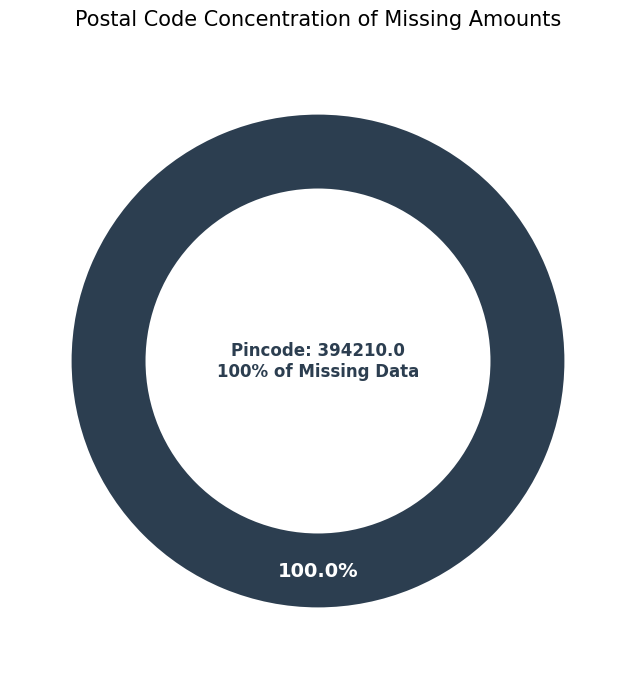

In [17]:
import matplotlib.pyplot as plt

# 1. Filter the data based on your condition
# Logic: Amount is missing but Quantity is not zero
missing_data = df[(df['Amount'].isna()) & (df['Qty'] != 0)]
postal_counts = missing_data['ship-postal-code'].value_counts()

# 2. Plotting
plt.figure(figsize=(8, 8), facecolor='white')

# We use a dark, elegant color like Midnight Blue (#2c3e50)
dark_color = ['#2c3e50'] 

plt.pie(postal_counts, 
        labels=postal_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=dark_color,
        pctdistance=0.85,
        textprops={'color':"white", 'weight':'bold', 'fontsize':14})

# 3. Create the Donut Hole for a modern look
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# 4. Add a central label to highlight the "Offender"
# This assumes there is only one pincode as you mentioned
top_pincode = postal_counts.index[0]
plt.annotate(f'Pincode: {top_pincode}\n100% of Missing Data', 
             (0,0), ha='center', va='center', 
             fontsize=12, fontweight='bold', color='#2c3e50')

plt.title('Postal Code Concentration of Missing Amounts', fontsize=15, pad=20)
plt.show()

### Insights:
##### We have the most missing amounts for this particular pincode. There are more cancellations, and delivery delays for this pincode than any other. Also, no particular amounts are shown only for this product. So further reporting is required

## 7. Most Styles Sold by Quantity

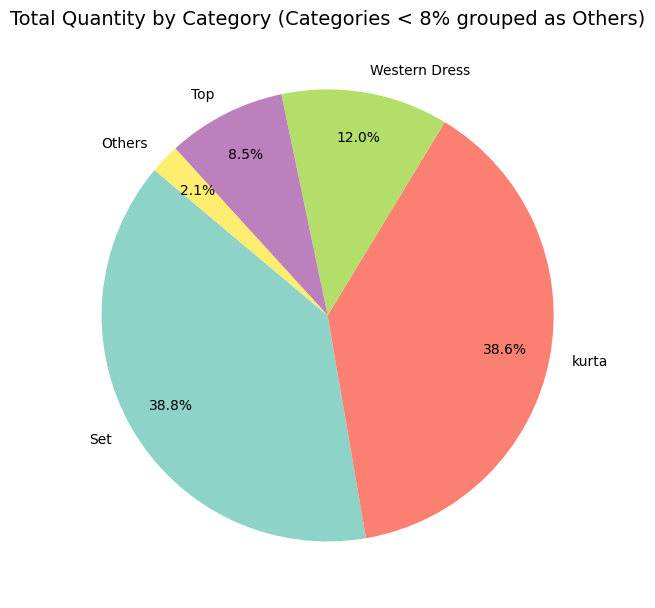

In [18]:
category_qty = df.groupby('Category')['Qty'].sum()

total_qty = category_qty.sum()
category_percentages = (category_qty / total_qty) * 100

threshold = 8.0
mask = category_percentages < threshold

top_categories = category_qty[~mask]
others_sum = category_qty[mask].sum()

plot_data = top_categories.copy()
if others_sum > 0:
    plot_data['Others'] = others_sum

plot_data = plot_data.sort_values(ascending=False)

plt.figure(figsize=(6, 8))
plot_data.plot(
    kind='pie', 
    autopct='%1.1f%%',      # Displays the calculated percentage
    startangle=140, 
    cmap='Set3', 
    pctdistance=0.80,       # Position of percentage text
    labeldistance=1.1       # Position of category labels
)

plt.title('Total Quantity by Category (Categories < 8% grouped as Others)', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

#### Contribution of B2B businesses on order contributions

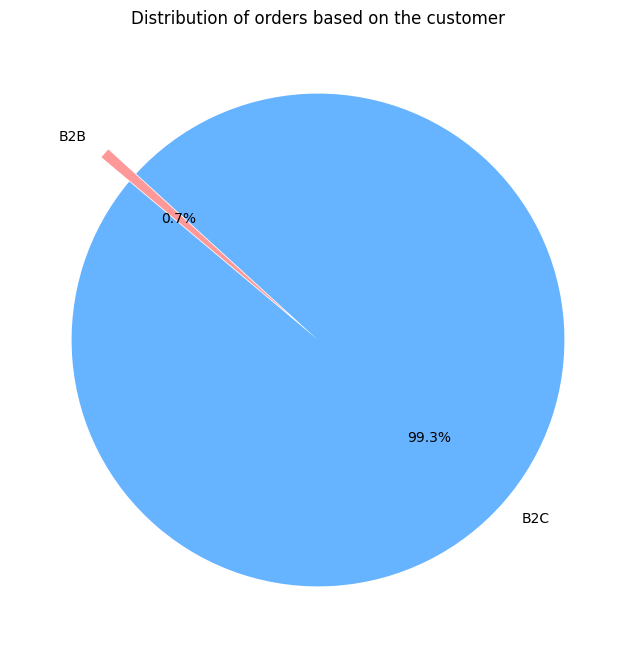

In [19]:
b2b_chart = df['B2B'].value_counts()
labels = ['B2B' if index == True else 'B2C' for index in b2b_chart.index]

plt.figure(figsize = (8,8))
plt.pie(
    b2b_chart, 
    labels = labels,
    autopct = '%1.1f%%',
    startangle = 140,
    colors = ['#66b3ff', '#ff9999'],
    explode=(0, 0.15) if len(b2b_chart) > 1 else None
)

plt.title('Distribution of orders based on the customer')
plt.show()

### Takeaway: Focus more on the retail customers, than the business customers

In [20]:
df['Status'].unique()

array(['Cancelled', 'Shipped - Delivered to Buyer', 'Shipped',
       'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer',
       'Shipped - Lost in Transit', 'Shipped - Out for Delivery',
       'Shipped - Returning to Seller', 'Shipped - Picked Up', 'Pending',
       'Pending - Waiting for Pick Up', 'Shipped - Damaged', 'Shipping'],
      dtype=object)

In [21]:
# import plotly.express as px
# import plotly.io as pio

# # 1. Force Jupyter to render the Plotly graph
# pio.renderers.default = 'notebook_connected'

# # 2. Prepare the data
# state_data = df.groupby('ship-state')['Order ID'].nunique().reset_index()
# state_data.columns = ['State', 'Order_Count']

# # 3. Comprehensive State Name Cleaning
# # Mapping your data strings to the exact strings in the GeoJSON
# state_mapping = {
#     'Delhi': 'NCT of Delhi',
#     'Andaman & Nicobar': 'Andaman & Nicobar Island',
#     'Dadra and Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
#     'Arunachal Pradesh': 'Arunachal Pradesh',
#     'Telangana': 'Telangana'
# }

# # Apply Title Case first, then apply the specific mapping fixes
# state_data['State'] = state_data['State'].str.title()
# state_data['State'] = state_data['State'].replace(state_mapping)

# # Remove 'nan' and 'Armed Forces Post Office' as they don't have map coordinates
# state_data = state_data.dropna(subset=['State'])
# state_data = state_data[state_data['State'] != 'Armed Forces Post Office']

# # 4. GeoJSON URL for India States
# india_states_url = "https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d1a4501f2ce8911ad99/raw/e38cfdac3641961c7145d7c40d84881854553b1b/india_states.geojson"

# # 5. Create the Figure
# fig = px.choropleth(
#     state_data,
#     geojson=india_states_url,
#     featureidkey='properties.ST_NM', # Matches the GeoJSON internal key
#     locations='State',               # Matches our 'State' column
#     color='Order_Count',
#     color_continuous_scale="Reds",
#     title='<b>Total Orders by State (Geographical Heatmap)</b>',
#     template='plotly_white',
#     labels={'Order_Count': 'Unique Orders'}
# )

# # 6. Focus the map on India specifically
# fig.update_geos(
#     fitbounds="locations", 
#     visible=False
# )

# # 7. Add layout adjustments for a cleaner look
# fig.update_layout(
#     margin={"r":0,"t":50,"l":0,"b":0},
#     title_x=0.5 # Center the title
# )

# # 8. Show the map
# fig.show()

In [22]:
df.loc[(df['Amount'].isna()) & (df['Qty'] != 0), 'ship-postal-code'].unique()

array([394210.])

In [23]:
df.loc[(df['ship-postal-code'] == 394210) & (df['Amount'].notna()), ~df.columns.isin(['SKU', 'Style'])]

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Category,Size,ASIN,...,Amount,ship-city,ship-state,ship-postal-code,B2B,Order Sucess,Weekday,Total items,is_cancelled,Month
2498,2498,404-5469072-1907536,2022-04-29,Shipped,amazon,amazon.in,expedited,Set,M,B09NQ4NM75,...,597.00,SURAT,Gujarat,394210.0,False,False,Friday,1,False,2022-04
3394,3394,408-4303365-7087517,2022-04-28,Shipped,amazon,amazon.in,expedited,Set,XXL,B09RKDZ461,...,909.00,SURAT,Gujarat,394210.0,False,False,Thursday,1,False,2022-04
13950,13950,406-2873303-0021139,2022-04-22,Shipped - Delivered to Buyer,merchant,amazon.in,standard,Set,3XL,B0894Y3VBB,...,654.00,SURAT,Gujarat,394210.0,False,True,Friday,1,False,2022-04
22728,22728,403-7228820-1446731,2022-04-17,Shipped,amazon,amazon.in,expedited,kurta,M,B081WSTXZ9,...,399.00,SURAT,Gujarat,394210.0,False,False,Sunday,3,False,2022-04
22729,22729,403-7228820-1446731,2022-04-17,Shipped,amazon,amazon.in,expedited,kurta,M,B08BFV1DVW,...,486.00,SURAT,Gujarat,394210.0,False,False,Sunday,3,False,2022-04
22730,22730,403-7228820-1446731,2022-04-17,Shipped,amazon,amazon.in,expedited,kurta,M,B081WY1SP3,...,399.00,SURAT,Gujarat,394210.0,False,False,Sunday,3,False,2022-04
22731,22731,403-3967314-1706758,2022-04-17,Shipped - Delivered to Buyer,merchant,amazon.in,standard,kurta,M,B08KRZRSCL,...,399.00,SURAT,Gujarat,394210.0,False,True,Sunday,1,False,2022-04
32477,32477,404-3615485-6982732,2022-04-11,Cancelled,merchant,amazon.in,standard,Set,XS,B09NQ4DD29,...,568.58,SURAT,Gujarat,394210.0,False,False,Monday,1,True,2022-04
55720,55720,403-3552176-4932347,2022-05-26,Shipped,amazon,amazon.in,expedited,Western Dress,XL,B09SDXRYBG,...,771.00,SURAT,Gujarat,394210.0,False,False,Thursday,1,False,2022-05
57208,57208,404-6393795-9942767,2022-05-25,Shipped - Delivered to Buyer,merchant,amazon.in,standard,Set,3XL,B0922TJXMK,...,537.00,Surat,Gujarat,394210.0,False,True,Wednesday,1,False,2022-05


In [24]:
# Calculate Revenue at Risk (Pending orders)
pending_mask = df['Status'].isin(['Pending', 'Shipped', 'Shipping'])
revenue_at_risk = df[pending_mask]['Amount'].sum()

# Calculate Aging (Assumes you have a 'Date' column)
# This finds how many orders are older than 3 days but not delivered
from datetime import datetime, timedelta
three_days_ago = datetime.now() - timedelta(days=3)
delayed_orders = df[pending_mask & (df['Date'] < three_days_ago)]

print(f"Total Revenue currently at risk: ₹{revenue_at_risk}")
print(f"Number of orders delayed beyond 3 days: {len(delayed_orders)}")

Total Revenue currently at risk: ₹50754526.0
Number of orders delayed beyond 3 days: 78470


------------------------------
     EXECUTIVE KPI REPORT     
------------------------------
Total Potential Revenue: ₹78,592,678.30
Revenue Lost (Cancelled): ₹7,034,199.30
Revenue at Risk (Pending): ₹50,946,664.00
Overall Success Rate: 22.3%
Avg. Pending Order Age: 46.6 Days
------------------------------


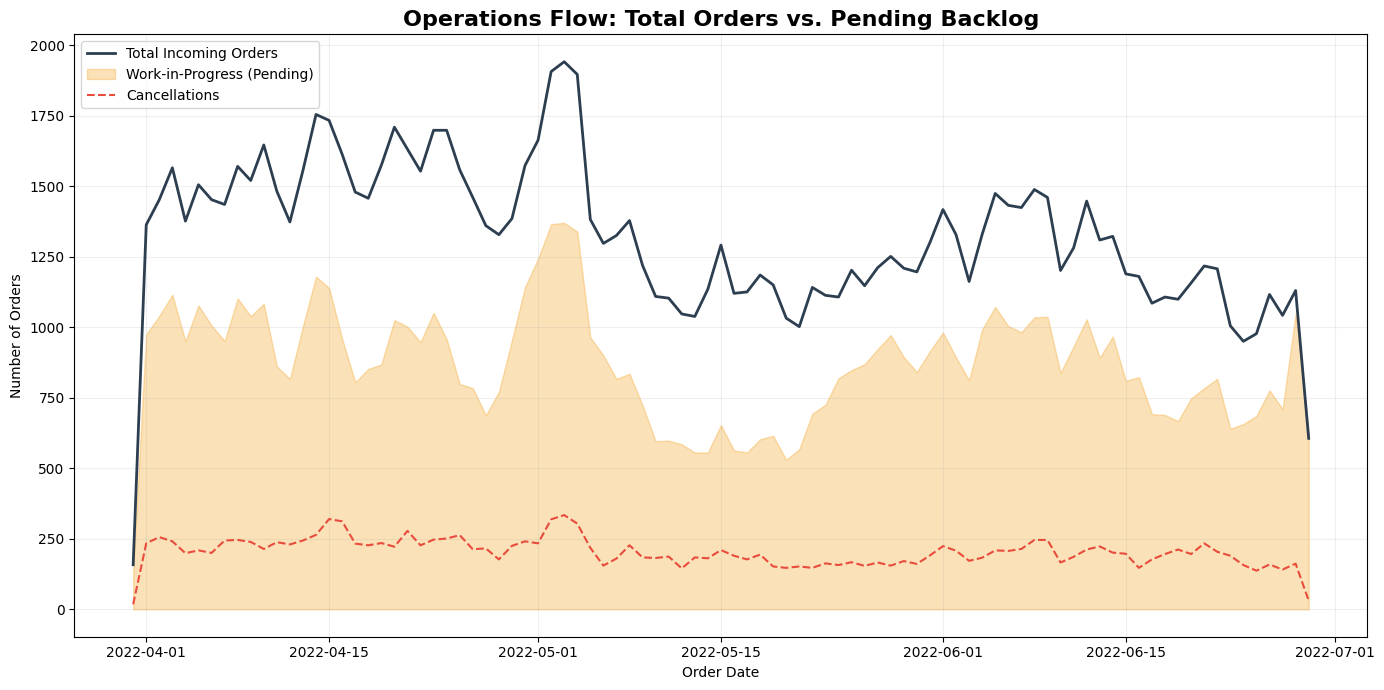